# Homework 2: Tagging and Parsing

Student Name: Yiheng Wang	

Student ID: 730536

Python version used: 2.7

## General info

<b>Due date</b>: 5pm, Thursday March 30

<b>Submission method</b>: see LMS

<b>Submission materials</b>: completed copy of this iPython notebook

<b>Late submissions</b>: -20% per day

<b>Marks</b>: 5% of mark for class

<b>Overview</b>: In this homework, you'll be building a hidden Markov (HMM) part-of-speech tagger and applying it to text. This includes training over labelled text, then prediction (decoding) to tag an unlabelled sentence and evaluating the result. The catch is that you're to do so using algorithms from probabilistic parsing. The HMM is a kind of weighted state-machine, which formally defines a (probablistic) regular language. Context free languages subsume the regular languages, and therefore a HMM is a specific type of PCFG. Your task will be to use this equivalence in order to implement HMM decoding using PCFG parsing routings, and use this for part-of-speech tagging. 

<b>Materials</b>: See the main class LMS page for information on the basic setup required for this class, including an iPython notebook viewer and the python packages NLTK, Numpy, Scipy, Matplotlib, Scikit-Learn, and Gemsim. In particular, if you are not using a lab computer which already has it installed, we recommend installing all the data for NLTK, since you will need various parts of it to complete this assignment. You can also use any Python built-in packages, but do not use any other 3rd party packages; if your iPython notebook doesn't run on the marker's machine, you will lose marks.  

<b>Evaluation</b>: Your iPython notebook should run end-to-end without any errors in a reasonable amount of time, and you must follow all instructions provided below, including specific implementation requirements and instructions for what needs to be printed (please avoid printing output we don't ask for). The amount each section is worth is given in parenthesis after the instructions. You will be marked not only on the correctness of your methods, but also the quality and efficency of your code: in particular, you should be careful to use Python built-in functions and operators when appropriate and pick descriptive variable names that adhere to <a href="https://www.python.org/dev/peps/pep-0008/">Python style requirements</a>. If you think it might be unclear what you are doing, you should comment your code to help the marker make sense of it.

<b>Extra credit</b>: Each homework has a task which is optional with respect to getting full marks on the assignment, but that can be used to offset any points lost on this or any other homework assignment (but not the final project or the exam). We recommend you skip over this step on your first pass, and come back if you have time: the amount of effort required to receive full marks (1 point) on an extra credit question will be substantially more than earning the same amount of credit on other parts of the homework.

<b>Updates</b>: Any major changes to the assignment will be announced via LMS. Minor changes and clarifications will be announced in the forum on LMS, we recommend you check the forum regularly.

<b>Academic Misconduct</b>: For most people, collaboration will form a natural part of the undertaking of this homework, and we encourge you to discuss it in general terms with other students. However, this ultimately is still an individual task, and so reuse of code or other instances of clear influence will be considered cheating. We will be checking submissions for originality and will invoke the University’s <a href="http://academichonesty.unimelb.edu.au/policy.html">Academic Misconduct policy</a> where inappropriate levels of collusion or plagiarism are deemed to have taken place.


## HMM Tagging

<b>Instructions</b>: For this homework we will be using the tagged sentences in the `nltk.corpus.treebank` corpus. You should start by accessing this dataset, using the `tagged_sents` method to access the sentences in the corpus, which are composed of pairs of tokens and their part of speech tags. For this homework, use all the `fileids` for training (we won't both with heldout validation or testing sets for the homework.) For each sentence, add special tokens, `<s>` and `</s>`, to the start and end. You should lower-case the tokens in the text, to limit the number of parameters in the model and allow for better generalisation.

Estimate the parameters of a _first order_ HMM tagger over the training partition. First order means that the transition probabilities depend on one previous tag, i.e., the A matrix stores $p(t | t')$ entries, where _t_ and _t'_ are the current and previous tag, respectively. Estimating the parameters (a.k.a. training) means learning the transition (A), observation (O) and starting state (pi) parameter. You will need to compute normalised frequency counts, as described in the lecture (and also the workshop and reading). You may want to store these using special dictionary variants from `collections`, such as `Counter` or `defaultdict`, or use `numpy.array` objects. Don't worry about smoothing the parameters for this homework. 

You should include in your transition parameters the transition to the `</s>` token, which ends the sequence. You may want to do the same for the `<s>` token, in which case the pi vector can be treated as a special row in A.

Your code should print out the following summary numbers: 1) the number of tag types, 2) the number of word tokens and word types (unique words), and 4) the number of parameters in each of A, O, and pi.

(1.5 marks)

In [1]:
from nltk.corpus import treebank
import numpy as np
from collections import Counter

corpus = treebank.tagged_sents()
#this list is used to store all the tags
tags = []
#this list is used to store all the (word,tag) pairs
observation = []
#this list is used to store all the words
words = []

for sent in corpus:
    sent.append(('</s>', 'END'))
    sent.insert(0,('<s>', 'START'))
    for word,tag in sent:
        tags.append(tag.lower())
        words.append(word.lower())
        observation.append((tag.lower(),word.lower()))

#this function is used to transfer the list into dictionary
def tagToDict(tags):
    Dict = {}
    for i in tags:
        Dict[i] = Dict.get(i,0) + 1
    return Dict

#this dictionary is used to store all tags and their counts
tags_counts = tagToDict(tags)
#this list is used to store Unique tags
tag_list = tags_counts.keys()
#this dictionary is used to store all words and their counts
words_counts = tagToDict(words)
#this list is used to store Unique words
words_list = words_counts.keys()

#the following two dicts are used for further (question 2 and 3) usages

#this dict is used to store each {(tag1,tag2),Prob(tag1 -> tag2)} pair
tag_tag_dict = {}
#this dict is used to store each {(tag,word),Prob(tag -> word)} pair
tag_word_dict = {}

#the matrix of A
A = np.zeros((len(tag_list),len(tag_list)))
#Here I use Counter to count each (tag,tag_next) pairs
countA = 0
for (x,y), count in Counter(zip(tags,tags[1:])).iteritems():
    prob = float(count)/tags_counts[x]
    A[tag_list.index(x),tag_list.index(y)] = prob
    tag_tag_dict[(x,y)] = prob
    countA += 1

#special condition, the next sentence's start will follow with end
#thus here we should set this kind of prob = 0
A[tag_list.index('end'),tag_list.index('start')] = 0
del tag_tag_dict[('end','start')]
countA -= 1

#the dictionary of Pi
pi = dict()
countPi = 0
for tag in tag_list:
    pi[tag] = A[tag_list.index('start'),tag_list.index(tag)]
    if pi[tag] != 0:
        countPi += 1
        
countO = 0
#the matrix of O
O = np.zeros((len(tag_list),len(words_list)))
pair = Counter(observation)
for tag,word in pair:
    prob = float(pair[(tag,word)])/tags_counts[tag]
    O[tag_list.index(tag),words_list.index(word)] = prob
    tag_word_dict[(tag,word)] = prob
    countO += 1

#Output
print "The number of tag types is: ",len(tag_list)
print "The number of word tokens is: ",len(words)
print "The number of word types is: ",len(words_list)
print "The number of parameters in A is: ",A.shape
print "non-zero number in A is: ", countA
print "The number of tags in O is: ",O.shape[0]
print "The number of words in O is: ",O.shape[1]
print "Non-zero number in O is: ", countO
print "The number of parameters in Pi is: ",len(pi)
print "Non-zero number in Pi is: ", countPi

The number of tag types is:  48
The number of word tokens is:  108504
The number of word types is:  11389
The number of parameters in A is:  (48, 48)
non-zero number in A is:  1047
The number of tags in O is:  48
The number of words in O is:  11389
Non-zero number in O is:  13155
The number of parameters in Pi is:  48
Non-zero number in Pi is:  36


<b>Instructions</b>: The next part requires thinking about the relationships between formal languages. Recall that the regular languages (including the HMM) are a subset of the context-free languages (PCFGs). Note that although we have _weighted (probabilistic)_ grammars, the same relation still holds. Your challenge is to figure out a _context-free grammar_ that corresponds to the HMM tagger, and the weighting of each production. 

To help get started, consider a part-of-speech tagged sentence, e.g., _`<s>` Donald/NNP has/VBZ small/JJ hands/NNS_ `</s>`.  The sequence of tags forms a chain, which is already a type of tree. Think about how this tagged sequence is scored by the HMM to compute the joint probability, which might help to figure out what non-terminal symbols you might need and where to attach a special _S_ start symbol.   

Use the HMM parameters computed above to construct a PCFG, using the `nltk.grammar.ProbabilisticProduction` and `nltk.grammar.PCFG` classes. This will require you to come up with a 'grammar' representation of the HMM, which you should create directly from your HMM parameters including the HMM probabilities in the PCFG productions. Your grammar should be in Chomsky Normal Form.

Finally, implement a probabilistic CYK parser using your tagging _PCFG_. Feel free to cut-and-paste code from the supplied notebooks, although ensure when you do this you clearly specify in comments the source of the code (and if you make changes to the copied code, then use comments to flag these changes.) Apply this "tagger" to the test sentence 

    <s> a dozen dinosaurs debate deals for daily dessert delivery . </s>

and print the predicted tree and the sequence of POS tags. During code development you may want to also view the chart.

*Note: Depending on how you go about this, you may need to relax the test for grammar validity in the `PCFG` constructor by changing the constant `nltk.grammar.PCFG.EPSILON`.* 

(2.5 marks)

In [2]:
#this cell is used to produce the grammar
from nltk.grammar import ProbabilisticProduction
from nltk.grammar import PCFG
from nltk.grammar import Nonterminal

productions = []
for (lhs,rhs),value in tag_word_dict.iteritems():
    if value > 0:
        #convert the lhs and rhs to Nonterminal form
        lhsX = lhs + "X"
        lhs = Nonterminal(lhs)
        lhsX = Nonterminal(lhsX)
        #tagX -> word [probability]
        rule = ProbabilisticProduction(lhsX,[rhs],prob=value)
        productions.append(rule)

for (lhs,rhs),value in tag_tag_dict.iteritems():
    if value > 0:
        lhsX = lhs + "X"
        lhs = Nonterminal(lhs)
        lhsX = Nonterminal(lhsX)
        rhs = Nonterminal(rhs)
        #tag -> tagX tag2 [probability]
        rule = ProbabilisticProduction(lhs,[lhsX,rhs],prob=value)
        productions.append(rule)

start = Nonterminal('start')
grammar = PCFG(start,productions)
#test if the grammar is in Chomsky Normal Form
print(grammar.is_chomsky_normal_form())

True


In [3]:
#this function is copied from WSTA_N6_probabilistic_parsing.ipynb
#and their is a change (as shown in the following code
#I just keep the comment in my changed place
from collections import defaultdict
import nltk
Output = []
def build_tree(words, back, symbol, i, j):
    backpointer = back[i, j].get(symbol)
    if backpointer == None:
        #store the POS of the current word
        POS = str(symbol).replace("X","")
        Output.append(POS)
        assert j == i+1
        return nltk.tree.Tree(symbol, [words[i]])
    else:
        k, prod = back[i, j][symbol]
        if k != None:
            left_subtree = build_tree(words, back, prod.rhs()[0], i=i, j=k)
            #change: if we do not reach to the end of the sentence,
            #we should call the function again, thus I added the following line
            if j != len(words):
                right_subtree = build_tree(words, back, prod.rhs()[1], i=k, j=j+1)
            else:
                right_subtree = build_tree(words, back, prod.rhs()[1], i=k, j=j)
                #at the end of the tree, get the POS
                print Output
            return nltk.tree.Tree(symbol, [left_subtree, right_subtree])
        else:
            subtree = build_tree(words, back, prod.rhs()[0], i=i, j=j)
            return nltk.tree.Tree(symbol, [subtree])

#this function is also copied from WSTA_N6_probabilistic_parsing.ipynb
#Similarly, I just keep the comment in my changed place
def parse_CYK(words, grammar):
    table = defaultdict(dict)
    back = defaultdict(dict)
    for j in range(1, len(words)+1):
        token = words[j-1]
        for prod in grammar.productions(rhs=token):
            if len(prod.rhs()) == 1:
                table[j-1,j][prod.lhs()] = prod.prob()

        changes = True
        cell = table[j-1,j]
        while changes:
            changes = False
            for non_term in list(cell.keys()):
                prob = cell[non_term]
                for prod in grammar.productions(rhs=non_term):
                    if len(prod.rhs()) == 1:
                        unary_prob = prod.prob() * prob
                        if unary_prob > cell.get(prod.lhs(), 0):
                            cell[prod.lhs()] = unary_prob
                            back[j-1,j][prod.lhs()] = (None, prod)
                            changes = True

        for i in range(j-2, -1, -1):
            cell = table[i,j]
            for k in range(i+1, j):
                left_cell = table[i,k]
                right_cell = table[k,j]
                for left_nt, left_prob in left_cell.items():
                    for prod in grammar.productions(rhs=left_nt):
                        if len(prod.rhs()) == 2:
                            # check if the left and right cells have a valid parse
                            #here, in order to follow our grammar's rule,
                            #we should change the format of tags
                            newTag = str(prod.rhs()[1]) + "X"
                            right_prob = right_cell.get(Nonterminal(newTag))
                            if left_prob != None and right_prob != None:
                                prob = prod.prob() * left_prob * right_prob
                                if prob > cell.get(prod.lhs(), 0.0):
                                    cell[prod.lhs()] = prob
                                    back[i,j][prod.lhs()] = (k, prod)

    #our backpointer is different, and only the adjacent words are 
    #connected
    return build_tree(words, back, grammar.start(), i=0, j=2)

['start', 'dt', 'nn', 'nns', 'nn', 'nns', 'in', 'jj', 'nn', 'nn', '.', 'end']


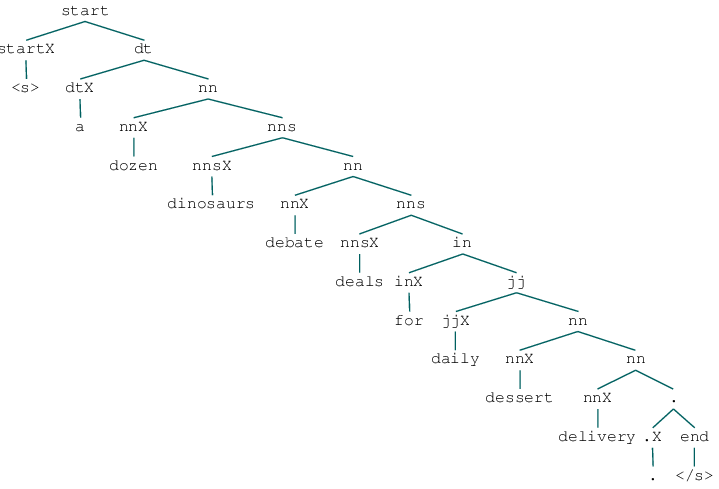

In [4]:
sentence = '<s> a dozen dinosaurs debate deals for daily dessert delivery . </s>'
Output = []
parse_CYK(sentence.split(), grammar)

**Instructions:** This approach is pretty slow, which you may notice if you apply your method to much longer senentences. Clearly the CYK algorithm is too general, and thus is not optimised for tagging grammars. Your job is to tailor the CYK algorithm to speed up its tagging performance. Start by pasting in a copy of the PCYK function from the notebook, and then make your edits. Please ensure that you clearly mark the parts you have changed with comments. You are free to sacrifice generality of the algorithm, so that it only works for your style of grammar. Are there aspects of your grammar that can be exploited by small changes to the parsing code? Looking carefully at the parse chart might help you to identify these opporunities. 

Print out the time of running the original CYK parsing for an example sentence, and the time for your improved method (you may want to use the `timeit` library.) Also print the tag predictions for both parsing methods, to verify that they produce the same results.

(1 mark)

In [7]:
#here I only keep the comments which show my changes.
#Firstly, delete the build tree function.
import timeit
def new_parse_CYK(words, grammar):
    #delete the dict of back, it is useless if we just need to find the tag
    table = defaultdict(dict)
    Output = []
    for j in range(1, len(words)+1):
        token = words[j-1]
        for prod in grammar.productions(rhs=token):
            #delete a line, in our case len(prod.rhs()) must be 1
            table[j-1,j][prod.lhs()] = prod.prob()

        #delete the while loop because in our grammar,
        #because when rhs=non_term, len(prod.rhs()) must be 2.
        count = 0
        tag = ''
        final_tag = ''
        #here we do not have to use the for loop, because we only care about
        #adjacent cells.
        if j > 1:
            i = j - 2
            cell = table[j-2,j]
            left_cell = table[i,i+1]
            right_cell = table[i+1,j]
            for left_nt, left_prob in left_cell.items():
                for prod in grammar.productions(rhs=left_nt):
                    newTag = str(prod.rhs()[1]) + "X"
                    right_prob = right_cell.get(Nonterminal(newTag))
                    #only need to check right_prob because the left one
                    #is always > 0
                    if right_prob != None:
                        prob = prod.prob() * left_prob * right_prob
                        if prob > cell.get(prod.lhs(), 0.0):
                            cell[prod.lhs()] = prob
                            #store the better tag
                            if prob > count:
                                count = prob
                                tag = prod.lhs()
                                if j == len(words):
                                    final_tag = prod.rhs()[1]

        Output.append(str(tag))
    
    Output.append(str(final_tag))
    del Output[0]
    print Output
    #our backpointer is different, and only the adjacent words are
    #connected
    return

In [9]:
#as you will see, the new method is about 5 times faster the original one
print 'As for the new method:'
start = timeit.default_timer()
new_parse_CYK(sentence.split(),grammar)
end = timeit.default_timer() - start
print end

As for the new method:
['start', 'dt', 'nn', 'nns', 'nn', 'nns', 'in', 'jj', 'nn', 'nn', '.', 'end']
0.00751996040344


In [11]:
Output = []
print 'As for the old method:'
start = timeit.default_timer()
parse_CYK(sentence.split(), grammar)
end = timeit.default_timer() - start
print end

As for the old method:
['start', 'dt', 'nn', 'nns', 'nn', 'nns', 'in', 'jj', 'nn', 'nn', '.', 'end']
0.038763999939


## Bonus: higher-order tagging

**Instruction:** Implement second order HMM tagger where the transition distribution considers the previous two tags as context, $p(t_i|t_{i-2},t_{i-1})$, in place of the single previous tag in the first order HMM. Feel free to go to even higher orders. You will have to be careful with low count events, as some perfectly valid sequences of three tags may not have been seen in training, so some smoothing will be needed. One simple method is to average the 1st order and 2nd order estimates, i.e., using for transition parameters $0.5 \times p(t_i|t_{i-2},t_{i-1}) + 0.5 \times p(t_i|t_{i-1})$. Your implementation should implement this HMM as an equivalent PCFG grammar, which you validate over the test sentence above (or other sentences you make up; but see OOV discussion below). 

(1 bonus mark) 

In [18]:
#Firstly, we should get the distribution of each P(ti | t(i-1),t(i-2))
#Let's look at the example: P(tag3 | tag2, tag1)
#It is equal to: Count(tag3, tag2, tag1) / Count(tag2, tag1)
#equal to: Count(tag3, tag2, tag1) / [ P(tag2 | tag1) * Count(tag1)]

#Therefore:

#step 1: get the distribution

#This list is used to store all the successive three tags
three_tag_list = []
corpus = treebank.tagged_sents()
for sent in corpus:
    sent.append(('</s>', 'END'))
    sent.insert(0,('<s>', 'START'))
    if len(sent) > 2:
        for i in range(0,len(sent)-2):
            three_tag_list.append((sent[i][1].lower(),sent[i+1][1].lower(),sent[i+2][1].lower()))

#This dictionary is used to count all the (tag1,tag2,tag3)
three_tag_count = tagToDict(three_tag_list)

# print three_tag_count

#this dictionary is used to store the probabilities of all the (tag1,tag2,tag3)
three_tag_dict = {}

for (tag1,tag2,tag3) in three_tag_count:
    count3 = three_tag_count[(tag1,tag2,tag3)]
    a = tag_tag_dict[(tag1,tag2)]
    count1 = tags_counts[tag1]
    count2 = a * count1
    three_tag_dict[(tag1,tag2,tag3)] = count3 / count2

In [19]:
#step 2: change the parser
#here the second order parser is based on new_parse_CYK in question 3
#Lines with comments are the place I changed the original parse.
def second_order_parse_CYK(words, grammar):
    table = defaultdict(dict)
    Output = []
    for j in range(1, len(words)+1):
        token = words[j-1]
        for prod in grammar.productions(rhs=token):
            table[j-1,j][prod.lhs()] = prod.prob()
            
        count = 0
        tag = ''
        final_tag = ''

        if j > 1:
            i = j - 2
            cell = table[j-2,j]
            left_cell = table[i,i+1]
            right_cell = table[i+1,j]   
            for left_nt, left_prob in left_cell.items():
                for prod in grammar.productions(rhs=left_nt):
                    newTag = str(prod.rhs()[1]) + "X"
                    right_prob = right_cell.get(Nonterminal(newTag))
                    if right_prob != None:
                        if j == 2:
                            prob = prod.prob() * left_prob * right_prob
                        else:
                            # p1 is p(tag3|tag2)
                            p1 = right_prob
                            tag1 = Addtag
                            tag2 = str(prod.lhs())
                            tag3 = str(prod.rhs()[1])
                            # p2 is p(tag3|tag2,tag1), if not in the dict,
                            # p2 will be set at 0
                            p2 = three_tag_dict.get((tag1,tag2,tag3), 0)
                            prob = prod.prob() * left_prob * (0.5 * p1 + 0.5 * p2)
                        if prob > cell.get(prod.lhs(), 0.0):
                            cell[prod.lhs()] = prob
                            if prob > count:
                                count = prob
                                tag = prod.lhs()               
                                if j == len(words):
                                    final_tag = prod.rhs()[1]
            
        Addtag = str(tag)
        Output.append(Addtag)
    
    Output.append(str(final_tag))
    del Output[0]
    print Output
    #our backpointer is different, and only the adjacent words are
    #connected
    return

second_order_parse_CYK(sentence.split(), grammar)
#As you can see, in this method, the tag of "debate" changed into "VB"

['start', 'dt', 'nn', 'nns', 'vb', 'nns', 'in', 'jj', 'nn', 'nn', '.', 'end']


## A final word

HMMs are not usually implemented as PCFGs, in practice. Instead more tailored and optimised algorithms are used which are specific to the HMM. This homework aims to emphasise the similarities between the two approaches, and elucidate the link between the CYK and Viterbi algorithms.

Another important aspect is handling out-of-vocabulary words OOVs, i.e., words encountered in testing but not seen in training. The test sentence above was constructed to avoid this issue, and I suggest that if you test with other sentences, that you keep to the training vocabulary. Dealing with OOVs is out of scope, for now, although we will discuss how these can be handled in various contexts later in the subject.